In [1]:
from fmm import Network,NetworkGraph,FastMapMatch,FastMapMatchConfig,UBODT
import pandas as pd
from shapely.wkt import loads
from shapely.geometry import LineString
import tracers as tr
import numpy as np
import os
import json

#load network data and graph 
network = Network("../osmnx_example/rome/edges.shp","fid", "u", "v")
print("Nodes {} edges {}".format(network.get_node_count(),network.get_edge_count()))
graph = NetworkGraph(network)

[2025-03-04 14:29:32.868] [info] [network.cpp:72] Read network from file ../osmnx_example/rome/edges.shp
Nodes 94384 edges 203976
[2025-03-04 14:29:34.813] [info] [network.cpp:172] Number of edges 203976 nodes 94384
[2025-03-04 14:29:34.813] [info] [network.cpp:173] Field index: id 19 source 0 target 1
[2025-03-04 14:29:34.998] [info] [network.cpp:176] Read network done.
[2025-03-04 14:29:34.999] [info] [network_graph.cpp:17] Construct graph from network edges start
[2025-03-04 14:29:35.029] [info] [network_graph.cpp:30] Graph nodes 94384 edges 203976
[2025-03-04 14:29:35.029] [info] [network_graph.cpp:31] Construct graph from network edges end


In [2]:
ubodt = UBODT.read_ubodt_csv("../osmnx_example/rome/ubodt.txt")

[2025-03-04 14:29:38.274] [info] [ubodt.cpp:208] Reading UBODT file (CSV format) from ../osmnx_example/rome/ubodt.txt
[2025-03-04 14:29:39.277] [info] [ubodt.cpp:236] Read rows 1000000
[2025-03-04 14:29:40.188] [info] [ubodt.cpp:236] Read rows 2000000
[2025-03-04 14:29:41.069] [info] [ubodt.cpp:236] Read rows 3000000
[2025-03-04 14:29:41.890] [info] [ubodt.cpp:236] Read rows 4000000
[2025-03-04 14:29:42.785] [info] [ubodt.cpp:236] Read rows 5000000
[2025-03-04 14:29:43.665] [info] [ubodt.cpp:236] Read rows 6000000
[2025-03-04 14:29:44.470] [info] [ubodt.cpp:236] Read rows 7000000
[2025-03-04 14:29:45.263] [info] [ubodt.cpp:236] Read rows 8000000
[2025-03-04 14:29:46.083] [info] [ubodt.cpp:236] Read rows 9000000
[2025-03-04 14:29:46.882] [info] [ubodt.cpp:236] Read rows 10000000
[2025-03-04 14:29:47.708] [info] [ubodt.cpp:236] Read rows 11000000
[2025-03-04 14:29:48.614] [info] [ubodt.cpp:236] Read rows 12000000
[2025-03-04 14:29:49.414] [info] [ubodt.cpp:236] Read rows 13000000
[2025-0

In [32]:
with open('datapath.json', 'r') as f:
    data = json.load(f)

root_path = data['data_path']

f1_scores = {}

# these users wont give an empty mm result for the last 2000 points
valid_users_list = [4, 21, 24, 44, 70, 120, 144, 145, 153, 156, 167, 173, 183, 200, 201, 205, 220, 233, 245, 250, 264, 275, 283, 304, 306, 317, 353, 363, 371]

for obfuscation_stdev in range(0, 150, 10):

    total_precision = 0
    total_recall = 0
    total_f1 = 0
    valid_users = 0

    for user_id in valid_users_list:
        user_path = f'{user_id}.csv'
        file_path = os.path.join(root_path, user_path)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, sep=",")
            df = df.rename(columns={"ID": "id", "Latitude": "x", "Longitude": "y", "Timestamp": "timestamp"})

            # Convert timestamp to epoch and sort by timestamp
            df["timestamp"] = pd.to_datetime(df["timestamp"], format="ISO8601", errors="coerce").astype(int) / 10**9
            df["timestamp"] = df["timestamp"].astype(int)
            df = df.sort_values(by="timestamp")

            # Limit to first 2000 points 
            df = df.iloc[:2000]

            # Create wkt from lat lon data
            original_linestring = LineString(zip(df["y"], df["x"]))
            original_wkt = original_linestring.wkt
            model = FastMapMatch(network, graph, ubodt)

            # Configuration params
            k = 8
            radius = 400 / 100_000
            gps_error = 75 / 100_000

            fmm_config = FastMapMatchConfig(k, radius, gps_error, obfuscation=False, reverse_tolerance=10)

            # mm on the original trajectory 
            result = model.match_wkt(original_wkt, fmm_config)

            if result.cpath: 
                print(f"Map matching succeeded for user {user_id}") 
                gt = loads(result.mgeom.export_wkt())  

                # Apply perturbation
                (space_noise, time_min_period) = (60.0, 90)
                trace = df[['y', 'x', 'timestamp']].to_numpy()
                trace = [tuple(x) for x in trace]
                trace = [(x[0], x[1], int(x[2])) for x in trace]

                perturbed_traces = tr.perturb_traces((space_noise, time_min_period), [trace])
                perturbed_trace = perturbed_traces[0]

                df_pert = pd.DataFrame(perturbed_trace, columns=["y", "x", "timestamp"])
                df_pert["id"] = df["id"].iloc[0]

                perturbed_linestring = LineString(zip(df_pert["y"], df_pert["x"]))
                perturbed_wkt = perturbed_linestring.wkt

                #changed emission prob distribution 
                obfuscation_error = obfuscation_stdev / 100_000

                total_error = np.sqrt(gps_error**2 + obfuscation_error**2)

                fmm_config_pert = FastMapMatchConfig(k, radius, total_error, obfuscation=False, reverse_tolerance=10)
                result_pert = model.match_wkt(perturbed_wkt, fmm_config_pert)

                if result_pert.cpath: 
                    perturbed_geom = loads(result_pert.mgeom.export_wkt())

                    # Calculate intersection length between GT and perturbed matched result
                    intersection = gt.intersection(perturbed_geom).length
                    gt_length = gt.length
                    mm_length = perturbed_geom.length

                    # Calculate precision, recall, and F1 score
                    precision = intersection / mm_length if mm_length > 0 else 0
                    recall = intersection / gt_length if gt_length > 0 else 0
                    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                    total_precision += precision
                    total_recall += recall
                    total_f1 += f1
                    valid_users += 1

    # precision, recall and f1
    if valid_users > 0:
        avg_precision = total_precision / valid_users
        avg_recall = total_recall / valid_users
        avg_f1 = total_f1 / valid_users
        f1_scores[obfuscation_stdev] = avg_f1

        print(f"Valid users: {valid_users}")
        print(f"Average Precision: {avg_precision}")
        print(f"Average Recall: {avg_recall}")
        print(f"Average F1 Score: {avg_f1}")

Map matching succeeded for user 4
Map matching succeeded for user 21
Map matching succeeded for user 24
Map matching succeeded for user 44
Map matching succeeded for user 70
Map matching succeeded for user 120
Map matching succeeded for user 144
Map matching succeeded for user 145
Map matching succeeded for user 153
Map matching succeeded for user 156
Map matching succeeded for user 167
Map matching succeeded for user 173
Map matching succeeded for user 183
[2025-03-04 16:29:44.968] [warning] [fmm_algorithm.cpp:290] Traj 0 unmatched as point 731 and 732 not connected
Map matching succeeded for user 200
Map matching succeeded for user 201
[2025-03-04 16:29:47.056] [warning] [fmm_algorithm.cpp:290] Traj 0 unmatched as point 158 and 159 not connected
Map matching succeeded for user 205
Map matching succeeded for user 220
Map matching succeeded for user 233
Map matching succeeded for user 245
Map matching succeeded for user 250
Map matching succeeded for user 264
Map matching succeeded for

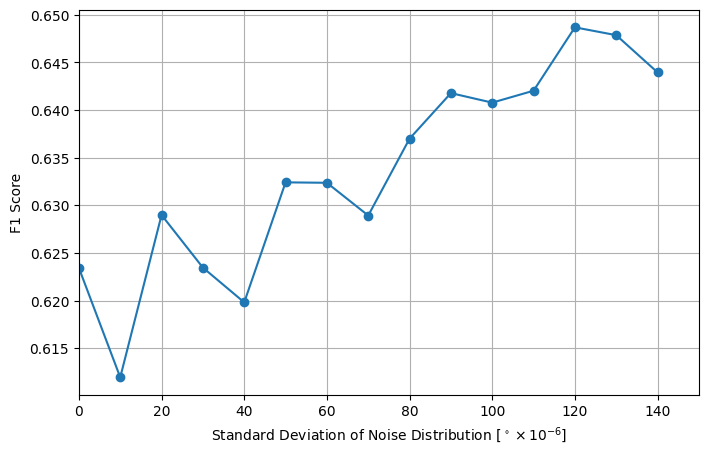

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(f1_scores.keys(), f1_scores.values(), marker='o', label="F1 Score")
plt.xlabel(r"Standard Deviation of Noise Distribution [$^\circ \times 10^{-6}$]")  # LaTeX notation
plt.xlim(0,150)
plt.grid()
plt.ylabel("F1 Score")
plt.show()